# Modelling

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_confusion_matrix
from IPython.core.display import display, HTML
import pickle


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('ignore')

In [2]:
import os
from twilio.rest import Client
import time


In [83]:
with open('../../../../../../Documents/chars.txt', 'r') as file:
    file = file.read().splitlines()
client = Client(file[0], file[1])

def message(body):
    mes = client.messages \
                .create(
                     body=body,
                     from_=file[2],
                     to=file[3])

In [85]:
file[3]

'+19197985366'

In [4]:
X =pd.read_csv('../data/interim/explantorydf.csv', index_col=0) #read in features and target(s)
y = pd.read_csv('../data/interim/targetdf.csv', index_col=0)

In [5]:
y_fatal= y['Fatal']
y_fatal

1          0
2          0
3          0
4          0
5          0
          ..
2055873    0
2055874    0
2055875    0
2055876    0
2055877    0
Name: Fatal, Length: 2055877, dtype: int64

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y_fatal, test_size=0.30, random_state=42)


In [14]:
y_test.value_counts(), y_train.value_counts()


(0    608524
 1      8240
 Name: Fatal, dtype: int64,
 0    1420075
 1      19038
 Name: Fatal, dtype: int64)

# Modelling


<p>   Being that this is a 3 category classification model, out of the box, the main models of interest are Decision Trees, Random Forests, and XGBoost, to start we will look at Logistic regression be interested to look at if we can predict only the fatalities.</p>

In [17]:
from sklearn.linear_model import LogisticRegression #import classifier
from sklearn.model_selection import RandomizedSearchCV


# First - Logistic - Just on the Fatal Category

In [21]:
logistic = LogisticRegression(solver='saga', 
                              tol=1e-2, 
                              max_iter=200,
                              random_state=0,
                              n_jobs=1,
                              class_weight='balanced')
distributions = dict(C=np.arange(0,11), penalty=['l2', 'l1', 'elasticnet'])
logclf = RandomizedSearchCV(logistic, distributions, random_state=0)

In [22]:
start = time.time()
search = logclf.fit(X_train, y_train)

TypeError: str() argument 2 must be str, not int

In [29]:
search.best_params_


{'penalty': 'l2', 'C': 8}

In [28]:
with open('../models/logistic.pkl', 'wb') as file:
    pickle.dump(search, file)

In [30]:

y_pred = search.predict(X_test)


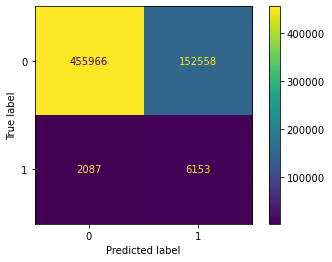

In [52]:
plot_confusion_matrix(search, X_test, y_test, labels = [0, 1])

<AxesSubplot:>

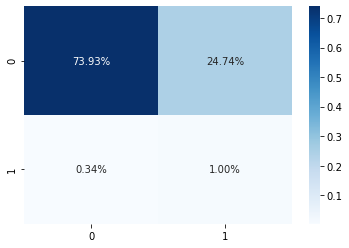

In [55]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [56]:
print(classification_report(y_pred, y_test, target_names=['Not Fatal', 'Fatal']))

              precision    recall  f1-score   support

   Not Fatal       0.75      1.00      0.86    458053
       Fatal       0.75      0.04      0.07    158711

    accuracy                           0.75    616764
   macro avg       0.75      0.52      0.46    616764
weighted avg       0.75      0.75      0.65    616764



In [57]:
y_pred_proba = search.predict_proba(X_test)[:,1]
y_pred_proba
y_pred_proba = y_pred_proba.reshape(-1, 1)
y_pred_proba.shape

(616764, 1)

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5, 1.0, 'ROC curve for Logistic Regression')

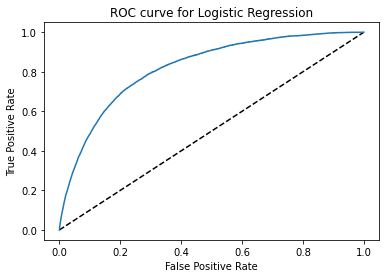

In [59]:
plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')

# Random Forest Modelling - Fatal vs. Non-Fatal

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
#RandomForestClassifier?

In [69]:
#play with Class weights

clf = RandomForestClassifier()

random_grid ={'max_depth': [2,5,7],
             'min_samples_leaf': [1, 3, 5],
             'min_samples_split': [2, 3, 4, 5],
             'n_estimators': [100],
             'class_weight' : ["balanced"]
             }

rfclf = RandomizedSearchCV(clf, param_distributions = random_grid, n_jobs=1)

In [70]:
start = time.time()
rfclf.fit(X_train, y_train)
message("Train_time="+str(round(((time.time()-start) /3600),3)) + ' hours')

TypeError: '_io.BufferedWriter' object is not subscriptable

In [72]:
with open('../models/rfmodel.pkl', 'wb') as file:
    pickle.dump(rfclf, file)
rfclf.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 7,
 'class_weight': 'balanced'}

In [73]:
y_pred = rfclf.predict(X_test)

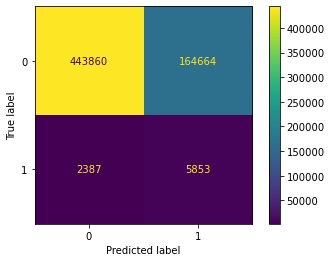

In [76]:
plot_confusion_matrix(rfclf, X_test, y_test, labels = [0, 1])

In [74]:
print(classification_report(y_test, y_pred, target_names=['Not Fatal', 'Fatal']))

              precision    recall  f1-score   support

   Not Fatal       0.99      0.73      0.84    608524
       Fatal       0.03      0.71      0.07      8240

    accuracy                           0.73    616764
   macro avg       0.51      0.72      0.45    616764
weighted avg       0.98      0.73      0.83    616764



In [32]:
y_pred_proba = rfclf.predict_proba(X_test)[:,1]
y_pred_proba
y_pred_proba = y_pred_proba.reshape(-1, 1)
y_pred_proba.shape

(616764, 1)

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5, 1.0, 'ROC curve for Random Forest Model')

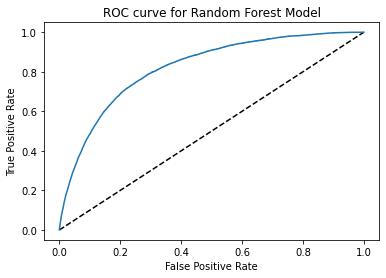

In [78]:
plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Model')

# XGB on Binary response (Fatal vs not Fatal)

In [107]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [111]:
XGBClassifier?

In [110]:
compute_sample_weight(class_weight='balanced', y=y_train)

array([0.50670317, 0.50670317, 0.50670317, ..., 0.50670317, 0.50670317,
       0.50670317])

In [122]:
xgbclf = XGBClassifier()
param_grid = {'max_depth': [1, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100],
        'scale_pos_weight' : [(y_train==0).sum()/ (y_train==1).sum()]}

In [119]:
(y_train==0).sum()/ (y_train==1).sum()

74.59160626116189

In [123]:
rdmxgb = RandomizedSearchCV(xgbclf, param_distributions = param_grid, n_jobs=1)

In [124]:
start = time.time()
rdmxgb.fit(X_train, y_train)
message('Train_time='+str(round(((time.time()-start) /3600),3)) + ' hours')

[19:53:21] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:57:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:06] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[21:02:45] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:05:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:06:06] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [129]:
with open('../models/xgbmodel.pkl', 'wb') as file:
    pickle.dump(rdmxgb, file)

In [125]:
y_pred = rdmxgb.predict(X_test)

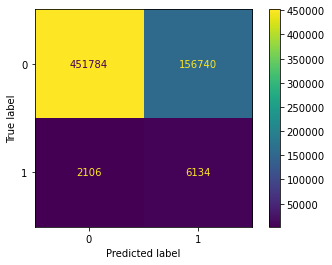

In [126]:
plot_confusion_matrix(rdmxgb, X_test, y_test, labels = [0, 1])

In [106]:
confusion_matrix(y_test, y_pred)

array([[608519,      5],
       [  8231,      9]], dtype=int64)

In [128]:
(y_test==1).sum()

8240

# Treating Fatal and Serious as one Class  vs  Slight

The above models do not show a reliable way to predict fatalities, based on our X features
So, I am going ot combined the "Fatal' and 'Serious' Classes together and repeat to see if results differ

In [36]:
y.head()

,Fatal,Serious,Slight
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1


In [41]:
y_fatalandserious = y['Fatal'] + y['Serious']


292460

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y_fatalandserious, test_size=0.30, random_state=42)

In [46]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                             random_state=0, n_jobs=-1)
distributions = dict(C=np.arange(0,11), penalty=['l2', 'l1', 'elasticnet'])
logclf = RandomizedSearchCV(logistic, distributions, random_state=0)

In [47]:
start = time.time()
logclf.fit(X_train, y_train)
message("Train_time="+str(round(((time.time()-start) /3600),3)) + ' hours')

In [48]:
logclf.best_params_

{'penalty': 'l2', 'C': 8}

In [50]:

y_pred = logclf.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    612099
           1       0.03      0.60      0.06      4665

    accuracy                           0.86    616764
   macro avg       0.51      0.73      0.49    616764
weighted avg       0.99      0.86      0.92    616764



Text(0.5, 1.0, 'ROC curve for Logistic Regression')

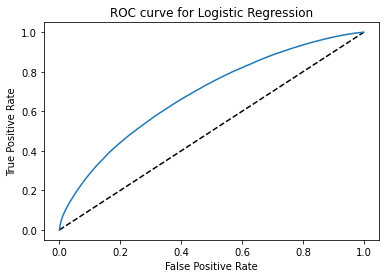

In [51]:
y_pred_proba = logclf.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')

In [57]:
clf = RandomForestClassifier()

random_grid ={'max_depth': [2,5,7],
             'min_samples_leaf': [1, 3, 5],
             'min_samples_split': [1, 3, 5]
             }

rfclf = RandomizedSearchCV(clf, param_distributions = random_grid, n_jobs=1)

In [58]:
start = time.time()
rfclf.fit(X_train, y_train)
message("Train_time="+str(round(((time.time()-start) /3600),3)) + ' hours')

In [59]:
rfclf.best_params_

{'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}

In [60]:
y_pred = rfclf.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92    528766
           1       0.00      0.00      0.00     87998

    accuracy                           0.86    616764
   macro avg       0.43      0.50      0.46    616764
weighted avg       0.74      0.86      0.79    616764



Text(0.5, 1.0, 'ROC curve for Random Forest Classifier')

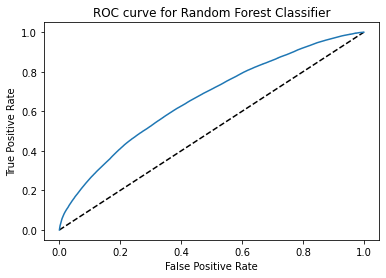

In [62]:
y_pred_proba = rfclf.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Classifier')

# USING XGBOOST Classifier


In [70]:
from xgboost import XGBClassifier

In [72]:
xgbclf = XGBClassifier(
                        )

In [73]:
start = time.time()
xgbclf.fit(X_train, y_train)
message("Train_time="+str(round(((time.time()-start) /3600),3)) + ' hours')

[19:27:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [74]:
y_pred = xgbclf.predict(X_test)

In [75]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    609047
           1       0.05      0.59      0.10      7717

    accuracy                           0.86    616764
   macro avg       0.52      0.73      0.51    616764
weighted avg       0.98      0.86      0.91    616764



Text(0.5, 1.0, 'ROC curve for Random Forest Classifier')

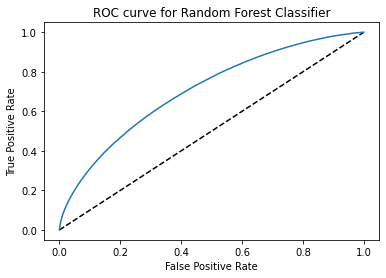

In [76]:
y_pred_proba = xgbclf.predict_proba(X_test)[:,1]
y_pred_proba = y_pred_proba.reshape(-1, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Classifier')